In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Monitoring air quality gained recently a lot of attention in the research community. It can assess the pollution levels and alarm people about a contaminated areas. Following on that, Zindi is hosting a [competiton](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge) to accurately forecast air quality (as measured by PM2.5 µ/m3) for each hour of the coming 25 hours across five locations in Kampala Uganda. Forecasts will be based on the past 5 days of hourly air quality measurements at each site. 

### Each sample in the provided dataset has a 121 hour readings of weather factors including:
- ### Temperature
- ### Percipiation
- ### Relative humidity
- ### Wind speed and direction
- ### Atmospheric pressure

### The target variable of each sample represents PM2.5 index measured 24 hours after the last weather readings. The readings are recorded from 5 different locations in Uganda. 

### You can download the comptition data from [here](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge/data).

# **Data Exploration**

### Let's start by exploring the challenge dataset

In [0]:
import pandas as pd
import numpy as np

In [0]:
data_path = 'fill it in with your path to data files'

train=pd.read_csv(data_path+"Train.csv")
test=pd.read_csv(data_path+"Test.csv")

In [0]:
test_id = test['ID'].tolist()

In [197]:
train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [198]:
print('Dataset keys:', train.keys())

Dataset keys: Index(['ID', 'location', 'temp', 'precip', 'rel_humidity', 'wind_dir',
       'wind_spd', 'atmos_press', 'target'],
      dtype='object')


### It seems that the time series of each waether factor is stored as comma separated string. Moreover, we have missing values :( .

### We will start by converting the dataframe to Numpy matrix of NxTxC where:
- ### N is the number of samples
- ### T is the legnth of time series
- ### C is the number of weather factors

In [0]:
def parse_ts_data(ts):
    """
    Inputs
    ts: a time series readings as string of comma separated values
    Outputs
    parsed_ts: numpy array of readings
    """
    ts = ts.replace("nan","-100").split(",") #replace nans with value differnt from all input values
    parsed_ts = np.array([float(t) for t in ts])
    return parsed_ts

def extract_time_series(df, feat_name):
    return np.array(df[feat_name].apply(lambda ts: parse_ts_data(ts)).tolist())

In [200]:
feat_name_arr = ['temp', 'precip', 'rel_humidity', 'wind_dir', 'wind_spd', 'atmos_press']

#Transform training data
train_time_series_feat = np.array([extract_time_series(train, feat_name) for feat_name in feat_name_arr]).transpose(1,2,0)
print('Shape of training data:', train_time_series_feat.shape)

#Transform test data
test_time_series_feat = np.array([extract_time_series(test, feat_name) for feat_name in feat_name_arr]).transpose(1,2,0)
print('Shape of test data:', test_time_series_feat.shape)

Shape of training data: (15539, 121, 6)
Shape of test data: (5035, 121, 6)


In [0]:
import matplotlib.pyplot as plt

## Weather Factors Exploration

### Let's plot the histogram of each weather factor

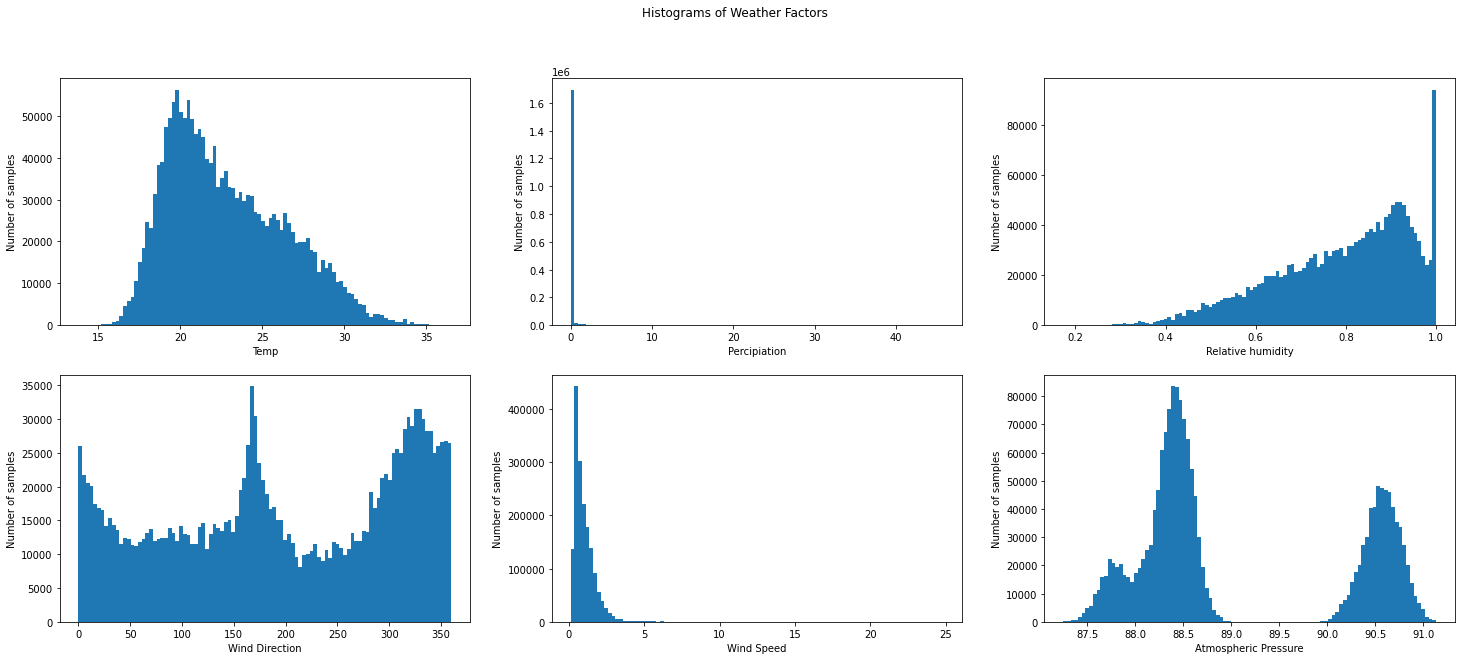

In [157]:
rng = np.arange(121)

fig, axs = plt.subplots(2, 3, figsize=(25,10))

valid_idx = np.where(train_time_series_feat[:,:,0] != -100)
axs[0, 0].hist(train_time_series_feat[:,:,0][valid_idx].flatten(), bins=100)
axs[0, 0].set(xlabel='Temp', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,1] != -100)
axs[0, 1].hist(train_time_series_feat[:,:,1][valid_idx].flatten(), bins=100)
axs[0, 1].set(xlabel='Percipiation', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,2] != -100)
axs[0, 2].hist(train_time_series_feat[:,:,2][valid_idx].flatten(), bins=100)
axs[0, 2].set(xlabel='Relative humidity', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,3] != -100)
axs[1, 0].hist(train_time_series_feat[:,:,3][valid_idx].flatten(), bins=100)
axs[1, 0].set(xlabel='Wind Direction', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,4] != -100)
axs[1, 1].hist(train_time_series_feat[:,:,4][valid_idx].flatten(), bins=100)
axs[1, 1].set(xlabel='Wind Speed', ylabel='Number of samples')
valid_idx = np.where(train_time_series_feat[:,:,5] != -100)
axs[1, 2].hist(train_time_series_feat[:,:,5][valid_idx].flatten(), bins=100)
axs[1, 2].set(xlabel='Atmospheric Pressure', ylabel='Number of samples')


fig.suptitle('Histograms of Weather Factors')
print()

### Let's have a look on one sample of the data.

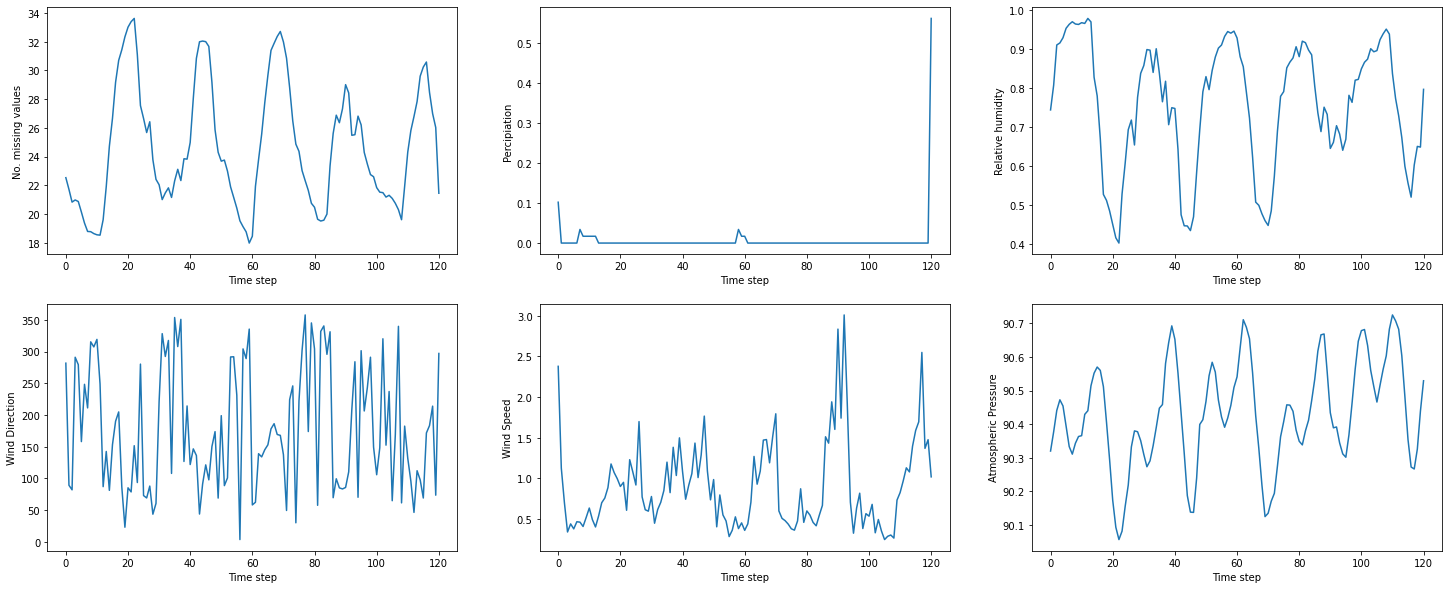

In [180]:
idx = 1

rng = np.arange(121)

fig, axs = plt.subplots(2, 3, figsize=(25,10))

axs[0, 0].plot(rng, train_time_series_feat[idx,:,0])
axs[0, 0].set(xlabel='Time step', ylabel='Temperature')
axs[0, 1].plot(rng, train_time_series_feat[idx,:,1])
axs[0, 1].set(xlabel='Time step', ylabel='Percipiation')
axs[0, 2].plot(rng, train_time_series_feat[idx,:,2])
axs[0, 2].set(xlabel='Time step', ylabel='Relative humidity')
axs[1, 0].plot(rng, train_time_series_feat[idx,:,3])
axs[1, 0].set(xlabel='Time step', ylabel='Wind Direction')
axs[1, 1].plot(rng, train_time_series_feat[idx,:,4])
axs[1, 1].set(xlabel='Time step', ylabel='Wind Speed')
axs[1, 2].plot(rng, train_time_series_feat[idx,:,5])
axs[1, 2].set(xlabel='Time step', ylabel='Atmospheric Pressure')

print()

### Let's have a look on the missing values at each time step for each of the weather factors. 

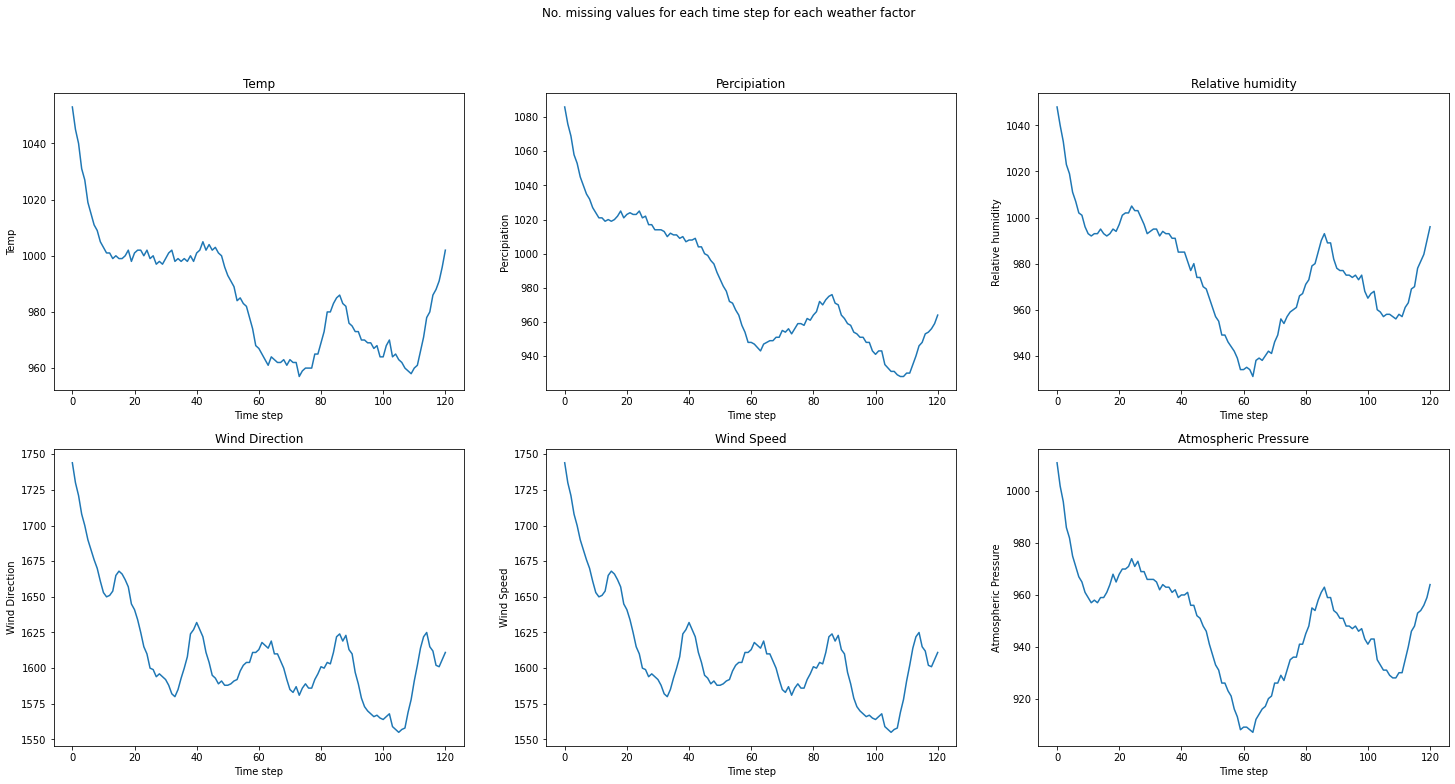

In [183]:
ts_missing_values = (train_time_series_feat == -100).sum(0)

rng = np.arange(121)

fig, axs = plt.subplots(2, 3, figsize=(25,12))

axs[0, 0].plot(rng, ts_missing_values[:,0])
axs[0, 0].set_title('Temp')
axs[0, 0].set(xlabel='Time step', ylabel='No. missing values')
axs[0, 1].plot(rng, ts_missing_values[:,1])
axs[0, 1].set_title('Percipiation')
axs[0, 1].set(xlabel='Time step', ylabel='No. missing values')
axs[0, 2].plot(rng, ts_missing_values[:,2])
axs[0, 2].set_title('Relative humidity')
axs[0, 2].set(xlabel='Time step', ylabel='No. missing values')
axs[1, 0].plot(rng, ts_missing_values[:,3])
axs[1, 0].set_title('Wind Direction')
axs[1, 0].set(xlabel='Time step', ylabel='No. missing values')
axs[1, 1].plot(rng, ts_missing_values[:,4])
axs[1, 1].set_title('Wind Speed')
axs[1, 1].set(xlabel='Time step', ylabel='No. missing values')
axs[1, 2].plot(rng, ts_missing_values[:,5])
axs[1, 2].set_title('Atmospheric Pressure')
axs[1, 2].set(xlabel='Time step', ylabel='No. missing values')

fig.suptitle('No. missing values for each time step for each weather factor')

print()

### It seems that all weather factors and time steps have missing values. So, we won't be easily git rid of missing values by droping any of the weather factors.

In [202]:
ts_missing_values = (train_time_series_feat == -100).sum((1,2)) > 0

print('Percentage of data samples that have any missing value:', ts_missing_values.mean())

Percentage of data samples that have any missing value: 0.5358774695926379


### Also, missing values exist in more than 50% of training data! 

## Locations Exploration

### Let's have a look on the locations

### Encode the location as numbers instead of strings

In [0]:
def encode_loc(df):
    d = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}
    return df['location'].apply(lambda x:d[x])

In [0]:
train_loc = encode_loc(train).values
test_loc = encode_loc(test).values

[Text(0, 0.5, 'No. samples'), Text(0.5, 0, 'Location')]

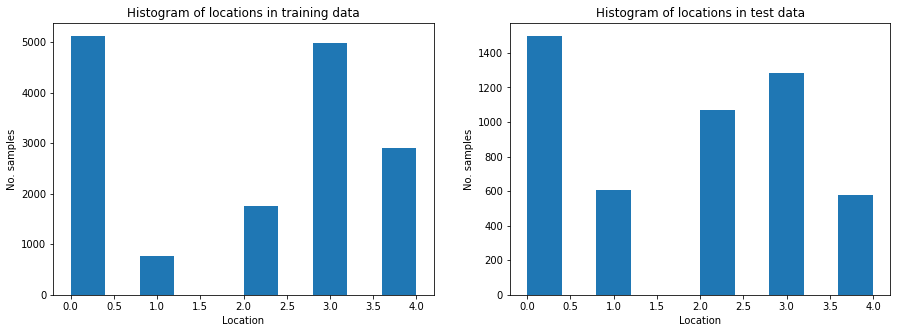

In [178]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].hist(train_loc)
axs[0].set_title('Histogram of locations in training data')
axs[0].set(xlabel='Location', ylabel='No. samples')
axs[1].hist(test_loc)
axs[1].set_title('Histogram of locations in test data')
axs[1].set(xlabel='Location', ylabel='No. samples')

### It seems that data were collected non-uniformly from locations. Also, the distribution is differnet in test data from training data. So, be careful!

### Extract target variable

In [0]:
train_target = train['target'].values.astype(np.float32)

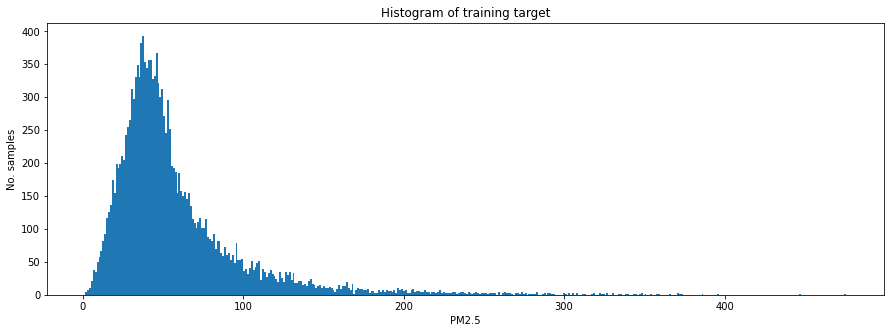

In [191]:
fig, axs = plt.subplots(1, figsize=(15,5))

axs.hist(train_target, bins=400)
axs.set_title('Histogram of training target')
axs.set(xlabel='PM2.5', ylabel='No. samples')
print()

# **Data Preprocessing**

### As for the normalization, we will apply the usual standard scaling using mean and std of each weather factor excluding the missing values.

In [0]:
time_series_feat = np.concatenate([train_time_series_feat, test_time_series_feat], axis = 0)

#data standardization
for c in range(time_series_feat.shape[2]):
    valid_idx = np.where(time_series_feat[:,:,c] != -100) #don't include missing values in normalization
    mean = time_series_feat[:,:,c][valid_idx].mean()
    std = time_series_feat[:,:,c][valid_idx].std()
    
    time_series_feat[:,:,c][valid_idx] -= mean
    time_series_feat[:,:,c][valid_idx] /= std

train_time_series_feat = time_series_feat[:train_loc.shape[0]]
test_time_series_feat = time_series_feat[train_loc.shape[0]:]

# **Training a CNN model on the data**

### Deep Learning achieves state of the art results on data with structure like images, text and time series as in our case. So In the next part in the notebook, we will train a multi-layer 1D Conv net using mean squared error loss. We will fill the missing values in the data with zeros (which the data mean anyway after normalization). 

### We will utilize pytorch library to train the model on colab GPU in couple of minutes!

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
import time
import copy

In [0]:
#Training loop adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = np.sqrt(running_loss / dataset_sizes[phase])

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss

In [0]:
#Dataset class. It returns the time series after filling missing values with zeros
class AirQo(Dataset):
    def __init__(self, time_series_feat, target, idx=None, split='train'):
        if idx is None:
            self.time_series_feat = time_series_feat
            self.target = target
        else:
            self.time_series_feat = time_series_feat[idx]
            self.target = target[idx]

        self.split = split

    def __len__(self):
        return self.time_series_feat.shape[0]

    def __getitem__(self, idx):
        x = self.time_series_feat[idx]
        x[x == -100] = 0
        x = x.transpose(1,0)
        if self.target is None:
            y = 0
        else:
            y = self.target[idx]
        return torch.FloatTensor(x), y

In [0]:
class ConvElu(nn.Module):
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        
        layers = [nn.Conv1d(ni, no, kernel, stride, pad), nn.ELU()]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

#5-layer convolutional neural networks followed by a linear layer for predciting PM2.5.
class ConvNet(nn.Module):
    def __init__(self, in_ch, kernel):
        """
        in_ch: number of input features for each time step
        kernel: kernel size of each conv layer
        """
        super(ConvNet, self).__init__()
        pad = kernel//2
        self.conv1 = ConvElu(in_ch, 32, kernel, 2, pad)
        self.conv2 = ConvElu(32, 64, kernel, 2, pad)
        self.conv3 = ConvElu(64, 128, kernel, 2, pad)
        self.conv4 = ConvElu(128, 256, kernel, 3, pad)
        self.conv5 = ConvElu(256, 512, kernel, 5, 1)
        self.conv_net = nn.Sequential(self.conv1, self.conv2, self.conv3, self.conv4, self.conv5)

        self.linear = nn.Linear(512, 1)

    def forward(self, x):
        sh = x.shape
        #pass to conv net
        x = self.conv_net(x)
        x = x.squeeze()
        #pass to output layer
        x = self.linear(x)
        return x

### The next piece of code trains the model in K-Fold style with K=5 and we will use the all models in testing afterwards. Since we noticed the non-uniform distribution of locations in the data, we will use stratified K-fold to make sure that each location is represnted in all folds.

In [0]:
#Setting all seeds for model reproducibility
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
sss = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)

In [210]:
device = torch.device("cuda:0")

models_arr = []
sc_arr = []
fold = 0

for train_index, val_index in sss.split(train_time_series_feat, train_loc):
    print('Training fold:', fold)
    fold += 1
    #create train, val and test dataset
    image_datasets = {'train': AirQo(train_time_series_feat, train_target, train_index),
		      'val': AirQo(train_time_series_feat, train_target, val_index, split = 'val'),
		      'test': AirQo(test_time_series_feat, None, split = 'val')}

    #create train and val dataloaders
    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=2),
                   'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=128, shuffle=False, num_workers=2)}

    #create model instance with kernel size of 7
    model = ConvNet(6, 7)
    model = model.to(device) #move it on GPU

    criterion = nn.MSELoss()

    dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}

    optimizer = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
    #To accelerate convergence, we will use One Cycle schedular introduced by super convergence paper (https://arxiv.org/abs/1708.07120).
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=len(dataloaders['train']), epochs=15)
    
    #train a model on this data split
    model, sc = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=15)
    sc_arr.append(sc**2)
    models_arr.append(model)

print()
print('mean rmse error of 5 folds:', np.sqrt(np.mean(sc_arr)))

0
Epoch 0/14
----------
train Loss: 57.2984
val Loss: 38.1457

Epoch 1/14
----------
train Loss: 37.0605
val Loss: 33.6169

Epoch 2/14
----------
train Loss: 34.8505
val Loss: 31.4149

Epoch 3/14
----------
train Loss: 34.3381
val Loss: 31.8210

Epoch 4/14
----------
train Loss: 34.1668
val Loss: 31.8385

Epoch 5/14
----------
train Loss: 33.8499
val Loss: 34.5516

Epoch 6/14
----------
train Loss: 32.7901
val Loss: 34.6549

Epoch 7/14
----------
train Loss: 31.5570
val Loss: 30.8073

Epoch 8/14
----------
train Loss: 29.3611
val Loss: 30.1526

Epoch 9/14
----------
train Loss: 27.4418
val Loss: 28.6450

Epoch 10/14
----------
train Loss: 25.1294
val Loss: 27.3752

Epoch 11/14
----------
train Loss: 21.9732
val Loss: 26.0030

Epoch 12/14
----------
train Loss: 19.4806
val Loss: 25.6463

Epoch 13/14
----------
train Loss: 16.7772
val Loss: 25.1740

Epoch 14/14
----------
train Loss: 15.2567
val Loss: 25.1196

Training complete in 0m 56s
Best val Loss: 25.119648
1
Epoch 0/14
----------
t

# **Make a submission**

In [0]:
#function to predict on the test set using the trained K models and average their output 
def predict_on_test(models_arr, loader, device):
    res = np.zeros((5035, 1), dtype = np.float32)
    for model in models_arr:
        model.eval()
        res_arr = []
        for inputs, _ in loader:
            inputs = inputs.to(device)
            #inputs_loc = inputs_loc.to(device)
            # forward
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                res_arr.append(outputs.detach().cpu().numpy())
        res_arr = np.concatenate(res_arr, axis = 0)
        res += res_arr
    return res / len(models_arr)

In [0]:
#predict on test set
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=128,shuffle=False, num_workers=4)
res = predict_on_test(models_arr, test_loader, device)

#write the results in submission file and save it.
sub = pd.read_csv(data_path+'sample_sub.csv')
sub['ID'] = test_id
sub['target'] = res.flatten().tolist()
sub.to_csv(data_path+'conv_net_5_folds_notebook.csv', index = False)

### You should be able to achieve a score of 40.997 approximately on the public leaderboard 